## Choosing the right Reasoning model and Reasoning effort for your use case 

Reasoning models, such as OpenAI’s o1 and o3-mini, are advanced language models trained with reinforcement learning to enhance complex reasoning. They generate a detailed internal thought process before responding, making them highly effective in problem-solving, coding, scientific reasoning, and multi-step planning for agentic workflows.

In this Cookbook, we will explore an Eval based quantiative analysis to help you choose the right reasoning model and reasoning effort for your use case. 

This is a 3 step process: 

1. Build Your Evaluation Dataset
2. Build a Pipeline to evaluate the reasoning model and capture metrics 
3. Choose the model/parameter based on cost/performance trade-off 

### Step 1: Build Your Evaluation Dataset 

For this example, we will use the AI2-ARC dataset

ARC-Challenge
id: a string feature.
question: a string feature.
choices: a dictionary feature containing:
text: a string feature.
label: a string feature.
answerKey: a string feature.

In [2]:
import requests

url = "https://huggingface.co/datasets/allenai/ai2_arc/resolve/main/ARC-Challenge/test-00000-of-00001.parquet"
response = requests.get(url)
with open("test-00000-of-00001.parquet", "wb") as f:
    f.write(response.content)

In [ ]:
import json
import pandas as pd

# Make sure to install the following packages:
# %pip install pandas pyarrow

# Set Pandas options to display full text in cells
pd.set_option('display.max_colwidth', None)

# Reads the Parquet file into a DataFrame.
df = pd.read_parquet("test-00000-of-00001.parquet")

# Convert the first row to a dictionary.
row_dict = df.head(1).iloc[0].to_dict()

# Pretty-print the row as a JSON string with an indentation of 4 spaces.
# The default lambda converts non-serializable objects (like numpy arrays) to lists.
print(json.dumps(row_dict, indent=4, default=lambda o: o.tolist() if hasattr(o, 'tolist') else o))


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
{
    "id": "Mercury_7175875",
    "question": "An astronomer observes that a planet rotates faster after a meteorite impact. Which is the most likely effect of this increase in rotation?",
    "choices": {
        "text": [
            "Planetary density will decrease.",
            "Planetary years will become longer.",
            "Planetary days will become shorter.",
            "Planetary gravity will become stronger."
        ],
        "label": [
            "A",
            "B",
            "C",
            "D"
        ]
    },
    "answerKey": "C"
}


In [4]:
total_rows = len(df)
print(f"Total number of rows in the dataset: {total_rows}")

# Display the total number of rows in the dataset


Total number of rows in the dataset: 1172


### Step 2: Build a Pipeline to evaluate the reasoning model and capture metrics 

Let's write a python script to evaluate the reasoning model and capture metrics. 


In [5]:
import time 
import openai
from openai import OpenAI

# Initialize the OpenAI client
client = OpenAI()


def response_with_reasoning_effort(model: str, question: str, reasoning_effort: str):
    """
    Send a question to the OpenAI model with a given reasoning effort level.

    Parameters:
        model (str): The name of the model.
        question (str): The input prompt.
        reasoning_effort (str): The reasoning effort level ("low", "medium", or "high").

    Returns:
        answer (str): The model's answer.
        usage: The usage object containing token counts.
        duration (float): Time taken for the API call.
    """

    start_time = time.time()

    # API Call
    response = client.chat.completions.create(
        model=model,
        reasoning_effort=reasoning_effort,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that provides answe to multiple choice questions. Reply only with the letter of the correct answer choice."},
            {"role": "user", "content": question}
        ]
    )

    end_time = time.time()

    # Extract answer from response.
    answer = response.choices[0].message.content.strip()
    usage = response.usage  # Contains prompt_tokens, total_tokens, and (optionally) reasoning_tokens.

    return answer, usage, (end_time - start_time)


id           938
question     938
choices      938
answerKey    938
dtype: int64

Run the pipeline for all the questions in the dataset. 

In [31]:
import time
import random
import re
import concurrent.futures
from tqdm import tqdm

models = ["o3-mini"]

results = []  # to accumulate results for each question, model, and reasoning level

# Sample 30% of the data for testing purposes
df_sample = df.sample(frac=0.8, random_state=42)
df_sample.count()

def process_question(row, model, reasoning_effort):
    try:
        q_text = str(row.question) + "\n" + "choices: " + str(row.choices)
        expected = row.answerKey

        answer, usage, duration = response_with_reasoning_effort(model, q_text, reasoning_effort)

        # Use regex to extract a single alphabet letter from the answer
        match = re.search(r'\b([A-Za-z])\b', answer)
        if match:
            extracted_answer = match.group(1).upper()
        else:
            extracted_answer = answer.strip().upper()

        expected_answer = str(expected).strip().upper()
        correct = extracted_answer == expected_answer

        result = {
            "id": row.id,
            "model": model,
            "level": reasoning_effort,
            "model_answer": extracted_answer,
            "correct": correct,
            "prompt_tokens": usage.prompt_tokens,
            "total_tokens": usage.total_tokens,
            "reasoning_tokens": usage.completion_tokens_details.reasoning_tokens,
            "duration": duration
        }

        # Add random time delay between 0.01 to 0.05 seconds
        time.sleep(random.uniform(0.01, 0.05))
        return result
    except TypeError as e:
        print(f"Error processing question: {row.id} with model {model} at reasoning level {reasoning_effort}: {e}")
        return None

# Use ThreadPoolExecutor to run API calls concurrently
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = []
    for _, row in df_sample.iterrows():
        for model in models:
            for reasoning_effort in ["low", "medium", "high"]:
                futures.append(executor.submit(process_question, row, model, reasoning_effort))
    
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing Questions"):
        res = future.result()
        if res is not None:
            results.append(res)

# Convert results to DataFrame for further analysis
df_results = pd.DataFrame(results)

Processing Questions: 100%|██████████| 2814/2814 [26:48<00:00,  1.75it/s] 


In [32]:
df_results


,id,model,level,model_answer,correct,prompt_tokens,total_tokens,reasoning_tokens,duration
0,Mercury_177870,o3-mini,low,C,True,129,141,0,1.895540
1,Mercury_177870,o3-mini,medium,C,True,129,141,0,2.160843
2,MDSA_2011_5_23,o3-mini,low,D,True,138,150,0,2.608335
3,MDSA_2011_5_23,o3-mini,medium,D,True,138,149,0,2.653007
4,Mercury_SC_413439,o3-mini,low,A,True,120,131,0,2.916875
...,...,...,...,...,...,...,...,...,...
2809,Mercury_7168805,o3-mini,high,B,True,162,494,320,5.438061
2810,NYSEDREGENTS_2010_4_30,o3-mini,high,B,True,169,436,256,10.122498
2811,Mercury_7168805,o3-mini,medium,B,True,162,302,128,9.560492
2812,ACTAAP_2014_5_8,o3-mini,high,B,True,147,1311,1152,8.942129


### Step 3: Choose the model/parameter based on cost/performance trade-off

Let's plot a graph between accuracy and latency for each model/reasoning effort pair.

In [48]:
# calculcate the average accuracy and latency for each model/reasoning effort pair
import numpy as np
import pandas as pd

df_results_grouped = df_results.groupby(['model', 'level']).agg({'accuracy': 'mean', 'duration': 'mean', 'reasoning_tokens': 'mean', 'total_tokens': 'mean'}).reset_index()
df_results_grouped


,model,level,accuracy,duration,reasoning_tokens,total_tokens
0,o3-mini,high,0.956290,6.302782,352.272921,488.555437
1,o3-mini,low,0.956290,2.261437,24.631130,160.679104
2,o3-mini,medium,0.959488,3.246041,105.756930,241.832623


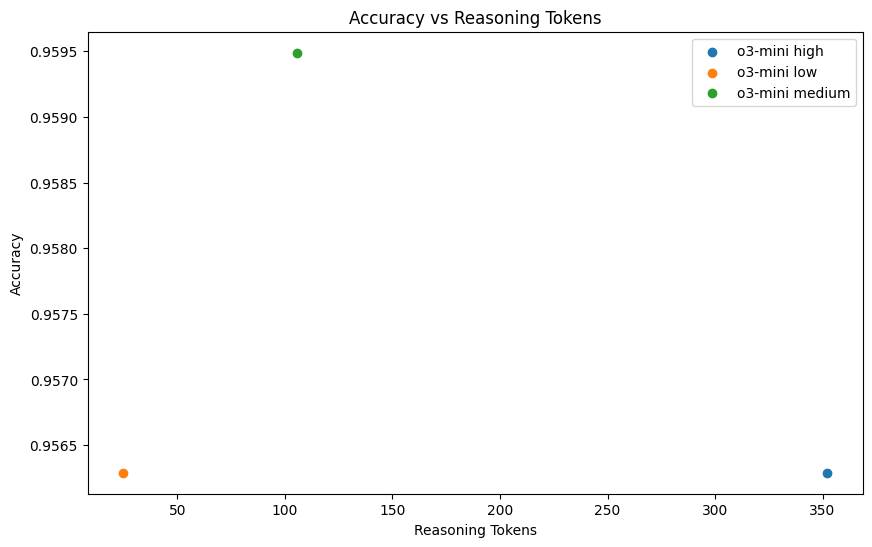

In [59]:
# scatter plot of reasoning tokens for every data point 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, row in df_results_grouped.iterrows():
    plt.scatter(row['reasoning_tokens'], row['accuracy'], label=f'{row["model"]} {row["level"]}')
plt.xlabel('Reasoning Tokens')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Reasoning Tokens')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Latency vs Reasoning Tokens')

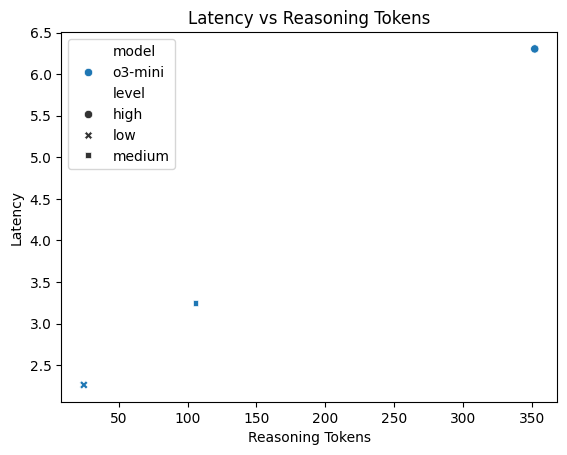

In [55]:
# create a cluster plot of latency vs reasoning tokens for each model/reasoning effort pair
import seaborn as sns

sns.scatterplot(data=df_results_grouped, x='reasoning_tokens', y='duration', hue='model', style='level')
plt.xlabel('Reasoning Tokens')
plt.ylabel('Latency')
plt.title('Latency vs Reasoning Tokens')